In [1]:

from pathlib import Path
import matplotlib.pyplot as plt
import lightning as L
import torch
import torch.nn as nn
from lit_llama import model
import random
from lit_llama import LLaMA, Tokenizer
from lit_llama.utils import EmptyInitOnDevice, lazy_load, llama_model_lookup

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
a = torch.Tensor([1,2,3])
b = torch.ones(10)

torch.cat([a,b])

tensor([1., 2., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [2]:
fabric = L.Fabric(devices=1)
tokenizer_path: Path = Path("checkpoints/lit-llama/tokenizer.model")
tokenizer = Tokenizer(tokenizer_path)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
import json
with open('datasets/alpaca_data_cleaned.json') as f:
    alpaca_json = json.load(f)

# Create tokenized j
alpaca_json_tokens = []

for index, item in enumerate(alpaca_json):
    alpaca_json_tokens.append(
        {
            'index': index,
            'instruction': tokenizer.encode(item['instruction'], bos=True, eos=False, device=fabric.device),
            'input': tokenizer.encode(item['input'], bos=False, eos=False, device=fabric.device),
            'output':tokenizer.encode(item['output'], bos=False, eos=True, device=fabric.device)
        }
    )

In [4]:
len(alpaca_json_tokens)

51760

In [5]:
prefix_tokens = nn.Embedding(51760, 4096)

In [6]:
def get_batch(dataset, batch_size=10):
    batch_indices = random.sample(range(len(dataset)), k=batch_size)
    
    # IST tokens
    IST_tokens = []
    for index in batch_indices:
        #llama_input = torch.cat([alpaca_json_tokens[index]['instruction'], alpaca_json_tokens[index]['input']]).unsqueeze(0)
        IST_tokens.append(prefix_tokens(torch.LongTensor([index])))

    # get shortest
    shortest_output_len = 1000
    for item in batch_indices:
        if(len(alpaca_json_tokens[item]['output']) < shortest_output_len):
            shortest_output_len = len(alpaca_json_tokens[item]['output'])


    length = random.randint(0,shortest_output_len-1)
    inputs = []
    targets = []

    for item in batch_indices:
        inputs.append(alpaca_json_tokens[item]['output'][:length])
        targets.append(alpaca_json_tokens[item]['output'][:length+1])
    
    return torch.stack(inputs), torch.stack(targets), torch.stack(IST_tokens)


In [7]:
from datasets import load_dataset
dataset = load_dataset('squad', split='train')


Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 2341.22it/s]


Dataset squad downloaded and prepared to /home/andrew/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


In [8]:
checkpoint_path: Path = Path("checkpoints/lit-llama/7B/lit-llama.pth")
tokenizer_path: Path = Path("checkpoints/lit-llama/tokenizer.model")

def load_LLaMA(checkpoint_path):
    with lazy_load(checkpoint_path) as checkpoint:
        name = llama_model_lookup(checkpoint)

        with EmptyInitOnDevice(
                device=fabric.device, dtype=dtype, quantization_mode=None # We won't quantize the weights
        ):
            model = LLaMA.from_name(name)

        model.load_state_dict(checkpoint)
    return model

In [9]:

dtype = torch.bfloat16 if fabric.device.type == "cuda" and torch.cuda.is_bf16_supported() else torch.float32

LLaMA_config = model.LLaMAConfig.from_name('7B')
print('Loading models...')
# Load the LLaMa model and the IST generator (also a LLaMA model)
LLamaModel = load_LLaMA(checkpoint_path).to(fabric.device)
#LLamaModel = LLaMA(LLaMA_config)
print('Finished loading the first model')
print('Finished loading models')
tokenizer = Tokenizer(tokenizer_path)

IST_schemes = ['vanilla', 'last 4', '2nd to last', 'all layers']
scheme_losses = {}

#IST_generator = model.Block(LLaMA_config)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(prefix_tokens.parameters(), lr=1e-4)
#IST_generator = IST_generator.to(fabric.device)

Loading models...
Finished loading the first model
Finished loading models


In [10]:
for param in LLamaModel.parameters():
    param.requires_grad=False

In [11]:
losses = []

In [12]:
optimizer = torch.optim.Adam(prefix_tokens.parameters(), lr=1e-3)

In [17]:
# Training loop
LLamaModel.train()
for epoch in range(1000):
    inputs, targets, IST_tokens = get_batch(alpaca_json_tokens,32)
    
    inputs = inputs.to(fabric.device)
    targets = targets.to(fabric.device)
    IST_tokens = IST_tokens.to(fabric.device)
    predicted_logits = LLamaModel(inputs, IST_tokens.type(torch.bfloat16))[0]
    loss = loss_fn(predicted_logits.permute(0,2,1).to(fabric.device), targets.type(torch.LongTensor).to(fabric.device))
    optimizer.zero_grad()
    loss.backward()
    print(f'epoch{epoch}, loss: {loss.item()}')
    losses.append(loss.item())
    optimizer.step()
    

epoch0, loss: 10.6875
epoch1, loss: 9.0625
epoch2, loss: 8.0625
epoch3, loss: 6.8125
epoch4, loss: 7.40625
epoch5, loss: 9.25
epoch6, loss: 7.28125
epoch7, loss: 7.0
epoch8, loss: 9.625
epoch9, loss: 9.3125
epoch10, loss: 9.0625
epoch11, loss: 7.78125
epoch12, loss: 9.9375
epoch13, loss: 8.4375
epoch14, loss: 10.1875
epoch15, loss: 8.1875
epoch16, loss: 8.0625
epoch17, loss: 9.1875
epoch18, loss: 7.03125
epoch19, loss: 8.125
epoch20, loss: 7.8125
epoch21, loss: 7.09375
epoch22, loss: 8.4375
epoch23, loss: 9.8125
epoch24, loss: 9.75
epoch25, loss: 9.375
epoch26, loss: 9.0
epoch27, loss: 8.125
epoch28, loss: 7.28125
epoch29, loss: 10.75
epoch30, loss: 9.5625
epoch31, loss: 7.65625
epoch32, loss: 8.5625
epoch33, loss: 9.375
epoch34, loss: 9.9375
epoch35, loss: 7.21875
epoch36, loss: 8.375
epoch37, loss: 6.5625
epoch38, loss: 7.75
epoch39, loss: 10.9375
epoch40, loss: 7.59375
epoch41, loss: 7.6875
epoch42, loss: 7.96875
epoch43, loss: 6.46875
epoch44, loss: 8.6875
epoch45, loss: 7.53125
ep

KeyboardInterrupt: 

Text(0, 0.5, 'loss')

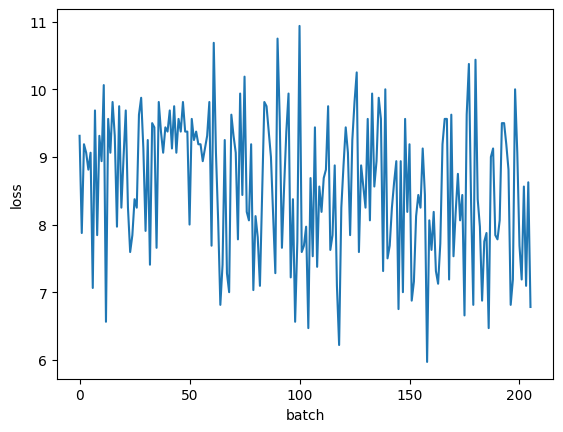

In [18]:
plt.plot(losses)
plt.xlabel('batch')
plt.ylabel('loss')

In [19]:
torch.save(prefix_tokens.state_dict(), 'prefix.pt')

In [20]:
torch.save(losses, 'prefix_losses.pt')

In [15]:
def get_IST(string):
    tokens = tokenizer.encode(string).unsqueeze(0).type(torch.LongTensor).to(fabric.device)
    x = LLamaModel(tokens)[1]
    x = IST_generator(x)
    return x[:,-1,:]

In [16]:
import generate
out = generate.generate(model=LLamaModel, 
                  idx=tokenizer.encode('').type(torch.LongTensor).to(fabric.device), 
                  max_new_tokens=200, 
                  max_seq_length=400,top_k=1, internal_state_tokens=get_IST('What are the three primary colors?').type(torch.bfloat16))[0]

print(tokenizer.decode(out))
